<a href="https://colab.research.google.com/github/gavinadlan/ArtsyMart/blob/main/Final_Exam_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, silhouette_score

**Load Dataset**

In [2]:
# Load dataset
df = pd.read_csv("netflix_titles.csv")

# Tampilkan 5 data pertama
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


**Preprocessing Data**

In [3]:
# Hapus kolom yang tidak relevan
df.drop(columns=["show_id", "title", "description", "director", "cast", "country", "date_added"], inplace=True, errors="ignore")

# Mengisi missing values dengan mode (nilai yang paling sering muncul)
df["rating"].fillna(df["rating"].mode()[0], inplace=True)
df["duration"].fillna("60 min", inplace=True)
df.fillna("Unknown", inplace=True)

# Konversi 'duration' ke angka (menit)
def convert_duration(value):
    if "min" in value:
        return int(value.replace(" min", ""))
    elif "Season" in value:
        return int(value.split(" ")[0]) * 60  # 1 season = 60 menit (asumsi)
    else:
        return 60

df["duration"] = df["duration"].apply(convert_duration)

# Menampilkan data setelah preprocessing
df.head()

<ipython-input-3-0c362841a9c5>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["rating"].fillna(df["rating"].mode()[0], inplace=True)
<ipython-input-3-0c362841a9c5>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

,type,release_year,rating,duration,listed_in
0,Movie,2020,PG-13,90,Documentaries
1,TV Show,2021,TV-MA,120,"International TV Shows, TV Dramas, TV Mysteries"
2,TV Show,2021,TV-MA,60,"Crime TV Shows, International TV Shows, TV Act..."
3,TV Show,2021,TV-MA,60,"Docuseries, Reality TV"
4,TV Show,2021,TV-MA,120,"International TV Shows, Romantic TV Shows, TV ..."


**One-Hot Encoding untuk Fitur Kategori**

In [4]:
# One-Hot Encoding untuk fitur kategori
categorical_cols = ["type", "rating", "listed_in"]

ohe = OneHotEncoder(sparse_output=False, drop="first")  # FIX: Gunakan sparse_output=False
categorical_data = ohe.fit_transform(df[categorical_cols])

# Konversi hasil encoding ke DataFrame
categorical_df = pd.DataFrame(categorical_data, columns=ohe.get_feature_names_out(categorical_cols))

# Gabungkan kembali dengan dataset utama
df = df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, categorical_df], axis=1)

# Menampilkan data setelah encoding
df.head()

,release_year,duration,type_TV Show,rating_74 min,rating_84 min,rating_G,rating_NC-17,rating_NR,rating_PG,rating_PG-13,...,"listed_in_TV Dramas, TV Sci-Fi & Fantasy, Teen TV Shows","listed_in_TV Dramas, TV Thrillers","listed_in_TV Dramas, Teen TV Shows","listed_in_TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","listed_in_TV Horror, TV Mysteries, TV Thrillers","listed_in_TV Horror, TV Mysteries, Teen TV Shows","listed_in_TV Horror, Teen TV Shows","listed_in_TV Sci-Fi & Fantasy, TV Thrillers",listed_in_TV Shows,listed_in_Thrillers
0,2020,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021,60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021,60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021,120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Normalisasi Data**

In [5]:
# Pilih hanya kolom numerik untuk normalisasi
numerical_cols = df.select_dtypes(include=["number"]).columns

# Normalisasi menggunakan StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])

# Simpan hasil normalisasi ke DataFrame baru
df_scaled = pd.DataFrame(X_scaled, columns=numerical_cols)

# Menampilkan hasil normalisasi
df_scaled.head()

,release_year,duration,type_TV Show,rating_74 min,rating_84 min,rating_G,rating_NC-17,rating_NR,rating_PG,rating_PG-13,...,"listed_in_TV Dramas, TV Sci-Fi & Fantasy, Teen TV Shows","listed_in_TV Dramas, TV Thrillers","listed_in_TV Dramas, Teen TV Shows","listed_in_TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","listed_in_TV Horror, TV Mysteries, TV Thrillers","listed_in_TV Horror, TV Mysteries, Teen TV Shows","listed_in_TV Horror, Teen TV Shows","listed_in_TV Sci-Fi & Fantasy, TV Thrillers",listed_in_TV Shows,listed_in_Thrillers
0,0.659930,-0.199757,-0.660659,-0.010656,-0.010656,-0.06839,-0.01846,-0.095744,-0.183536,4.119887,...,-0.010656,-0.023834,-0.02611,-0.021316,-0.021316,-0.010656,-0.015071,-0.010656,-0.042662,-0.086229
1,0.773324,0.322077,1.513640,-0.010656,-0.010656,-0.06839,-0.01846,-0.095744,-0.183536,-0.242725,...,-0.010656,-0.023834,-0.02611,-0.021316,-0.021316,-0.010656,-0.015071,-0.010656,-0.042662,-0.086229
2,0.773324,-0.721592,1.513640,-0.010656,-0.010656,-0.06839,-0.01846,-0.095744,-0.183536,-0.242725,...,-0.010656,-0.023834,-0.02611,-0.021316,-0.021316,-0.010656,-0.015071,-0.010656,-0.042662,-0.086229
3,0.773324,-0.721592,1.513640,-0.010656,-0.010656,-0.06839,-0.01846,-0.095744,-0.183536,-0.242725,...,-0.010656,-0.023834,-0.02611,-0.021316,-0.021316,-0.010656,-0.015071,-0.010656,-0.042662,-0.086229
4,0.773324,0.322077,1.513640,-0.010656,-0.010656,-0.06839,-0.01846,-0.095744,-0.183536,-0.242725,...,-0.010656,-0.023834,-0.02611,-0.021316,-0.021316,-0.010656,-0.015071,-0.010656,-0.042662,-0.086229


**Menentukan Jumlah Cluster Optimal**

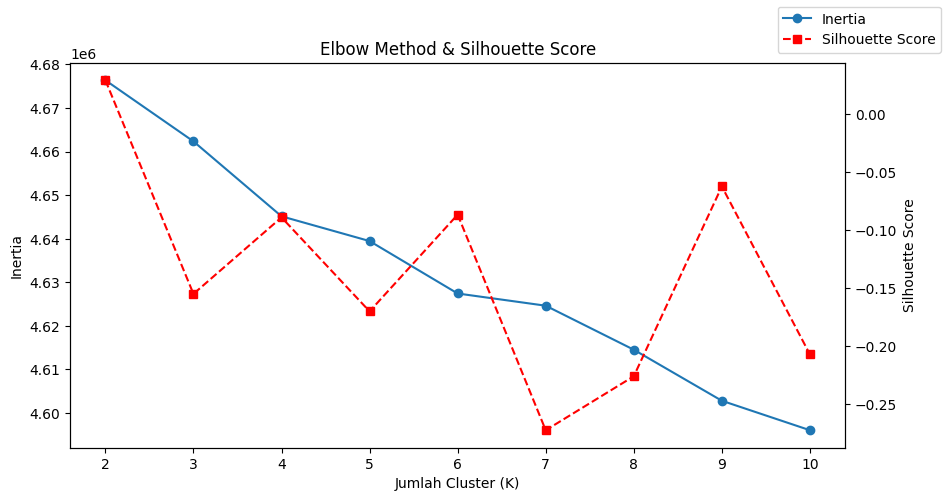

In [6]:
# Elbow Method & Silhouette Score
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, cluster_labels))

# Plot Elbow Method & Silhouette Score
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(K_range, inertia, marker="o", linestyle="-", label="Inertia")
ax1.set_xlabel("Jumlah Cluster (K)")
ax1.set_ylabel("Inertia")
ax1.set_title("Elbow Method & Silhouette Score")

ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_scores, marker="s", linestyle="--", color="red", label="Silhouette Score")
ax2.set_ylabel("Silhouette Score")

fig.legend()
plt.show()

**Clustering dengan K-Means**

In [7]:
# Clustering dengan K-Means (misalnya K=4 berdasarkan hasil Elbow Method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df_scaled)

# Menampilkan data setelah clustering
df.head()

,release_year,duration,type_TV Show,rating_74 min,rating_84 min,rating_G,rating_NC-17,rating_NR,rating_PG,rating_PG-13,...,"listed_in_TV Dramas, TV Thrillers","listed_in_TV Dramas, Teen TV Shows","listed_in_TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","listed_in_TV Horror, TV Mysteries, TV Thrillers","listed_in_TV Horror, TV Mysteries, Teen TV Shows","listed_in_TV Horror, Teen TV Shows","listed_in_TV Sci-Fi & Fantasy, TV Thrillers",listed_in_TV Shows,listed_in_Thrillers,cluster
0,2020,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2021,120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2021,60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2021,60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2021,120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Machine Learning (Random Forest Classifier)**

In [8]:
# Cek nama kolom setelah preprocessing
print("Kolom dalam dataset setelah preprocessing:", df.columns)

# Cari kolom target yang terkait 'type' (karena sudah di-One-Hot Encoding)
target_column = [col for col in df.columns if "type" in col]
print("Kolom target yang digunakan:", target_column)

if target_column:
    y = df[target_column[0]]  # Gunakan salah satu kolom hasil encoding
    X = df.drop(columns=target_column, errors="ignore")  # FIX: Hindari error jika kolom tidak ada
else:
    raise KeyError("Kolom 'type' tidak ditemukan setelah preprocessing!")

# Split dataset untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model klasifikasi (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediksi dan evaluasi model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model dengan Clustering: {accuracy:.4f}")

Kolom dalam dataset setelah preprocessing: Index(['release_year', 'duration', 'type_TV Show', 'rating_74 min',
       'rating_84 min', 'rating_G', 'rating_NC-17', 'rating_NR', 'rating_PG',
       'rating_PG-13',
       ...
       'listed_in_TV Dramas, TV Thrillers',
       'listed_in_TV Dramas, Teen TV Shows',
       'listed_in_TV Horror, TV Mysteries, TV Sci-Fi & Fantasy',
       'listed_in_TV Horror, TV Mysteries, TV Thrillers',
       'listed_in_TV Horror, TV Mysteries, Teen TV Shows',
       'listed_in_TV Horror, Teen TV Shows',
       'listed_in_TV Sci-Fi & Fantasy, TV Thrillers', 'listed_in_TV Shows',
       'listed_in_Thrillers', 'cluster'],
      dtype='object', length=533)
Kolom target yang digunakan: ['type_TV Show']
Akurasi Model dengan Clustering: 0.9938
